In [1]:
# coding: utf-8
"""
author: Carlos Loucera
email: carlos.loucera@juntadeandalucia.es

Analise pre-trained models.
"""
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut

import mlgut.stability as stab
from mlgut import utils, datasets
from mlgut.datasets import get_path
from mlgut.models import (
    compute_rbo_mat,
    compute_support_ebm,
    get_cp_support,
    get_lopo_support
)

import dotenv
import pathlib

EXTENSIONS = ["pdf", "png", "svg"]

PROJECT_NAMES_DICT = {
    "PRJNA389927": "Hannigan",
    "PRJEB12449": "Vogtmann",
    "PRJEB6070": "Zeller",
    "PRJEB7774": "Feng",
    "PRJEB10878": "Yu",
    "PRJNA447983": "Thomas0",
    "PRJEB27928": "Thomas1",
}

PROJECT_ORDER = sorted(PROJECT_NAMES_DICT.values())
DISEASE_COLUMN_NAME = "DISEASE"
PROJECT_COLUMN_NAME = "SECONDARY_STUDY_ID"


def load_crossproject(condition, profile, path):
    crossproject_fname = f"{condition}_{profile}_cross_project.jbl"
    crossproject_fpath = path.joinpath(crossproject_fname)
    crossproject_results = joblib.load(crossproject_fpath)
    crossproject_results = utils.rename_keys(crossproject_results, PROJECT_NAMES_DICT)

    return crossproject_results


def load_stability(condition, profile, path):
    stability_fname = f"{condition}_{profile}_stability.jbl"
    stability_fpath = path.joinpath(stability_fname)
    stability_results = joblib.load(stability_fpath)
    stability_results = utils.rename_keys(stability_results, PROJECT_NAMES_DICT)

    return stability_results


def compute_error(results, alpha=0.05, metric="roc_auc"):
    # Z matrix in Nogueira's stability paper
    metric_str = f"test_{metric}"
    scores = np.array(results[metric_str])
    n_splits = scores.size

    mean_score = np.mean(scores)
    ci = stats.norm.ppf(1 - alpha / 2) * (np.std(scores)) / np.sqrt(n_splits)

    return scores, mean_score, ci


def compute_stability(results, alpha=0.05):
    # Z matrix in Nogueira's stability paper

    support_matrix = [
        model["selector"].get_support() * 1 for model in results["estimator"]
    ]
    support_matrix = np.array(support_matrix)

    stab_res = stab.confidenceIntervals(support_matrix, alpha=alpha)
    stability = stab_res["stability"]
    stability_error = stab_res["stability"] - stab_res["lower"]

    return support_matrix, stability, stability_error


def analyze_stability(
    stability_results, crossproject_results, condition, profile, path
):
    stability_results_df = {
        key: compute_stability(stability_results[key])[1:]
        for key in stability_results.keys()
    }
    stability_results_df = pd.DataFrame(
        stability_results_df, index=["estability", "error"]
    )
    stability_results_df = stability_results_df.T.sort_index()

    crossproject_results_df = {
        key: compute_stability(crossproject_results[key]["cv"])[1:]
        for key in crossproject_results.keys()
    }
    crossproject_results_df = pd.DataFrame(
        crossproject_results_df, index=["estability", "error"]
    )
    crossproject_results_df = crossproject_results_df.T.sort_index()

    roc_auc_stability = {
        key: compute_error(stability_results[key])[0]
        for key in stability_results.keys()
    }

    roc_auc_stability = pd.DataFrame(roc_auc_stability).melt(
        value_name="Mean AUROC", var_name="Project"
    )

    roc_auc_crossproject = {
        key: compute_error(crossproject_results[key]["cv"])[0]
        for key in crossproject_results.keys()
    }
    roc_auc_crossproject = pd.DataFrame(roc_auc_crossproject).melt(
        value_name="Mean AUROC", var_name="Project"
    )

    plot_stability(
        crossproject_results_df, stability_results_df, condition, profile, path
    )
    plot_error(roc_auc_crossproject, roc_auc_stability, condition, profile, path)

    return roc_auc_crossproject


def plot_stability(cp_df, stab_df, condition, profile, path):
    plt.style.use("fivethirtyeight")
    _, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.errorbar(
        x=cp_df.index,
        y=cp_df["estability"],
        yerr=cp_df["error"],
        label=["CV-stability"],
    )
    plt.errorbar(
        x=stab_df.index,
        y=stab_df["estability"],
        yerr=stab_df["error"],
        label=["RSSS-stability"],
    )
    ax.set_xlabel("Project")
    ax.set_ylabel("Stability")
    plt.legend(loc="lower right")
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_feature_selection_stability.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def plot_error(cp_df, stab_df, condition, profile, path):
    _, ax = plt.subplots(1, 1, figsize=(16, 9))

    sns.lineplot(
        x="Project",
        y="Mean AUROC",
        data=cp_df,
        ax=ax,
        err_style="bars",
        ci=95,
        label="CV-test",
    )
    sns.lineplot(
        x="Project",
        y="Mean AUROC",
        data=stab_df,
        ax=ax,
        err_style="bars",
        ci=95,
        label="RSSS-test",
    )
    plt.legend(loc="lower right")
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_feature_selection_stability_error.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def analyze_rank_stability(results, features, profile, condition, path):
    def compute_ebm_fi_by_project(results, key):
        ebm_fi_list = [
            pd.Series(compute_support_ebm(model)[1], index=features.columns)
            for model in results[key]["cv"]["estimator"]
        ]
        ebm_fi = pd.concat(ebm_fi_list, axis=1)

        return ebm_fi

    ebm_fi_by_project = {
        key: compute_ebm_fi_by_project(results, key) for key in results.keys()
    }

    dmat = {
        key: compute_rbo_mat(ebm_fi_by_project[key]) for key in ebm_fi_by_project.keys()
    }

    dmat = pd.DataFrame(dmat).melt(value_name="dRBO", var_name="Project")
    fname = f"{condition}_{profile}_rank_stability_mat.jbl"
    fpath = path.joinpath(fname)
    joblib.dump(dmat, fpath)

    plt.figure(figsize=(16, 9))
    sns.violinplot(x="Project", y="dRBO", data=dmat, order=PROJECT_ORDER)
    plt.ylim([-0.1, 1.1])
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_rank_stability.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def analyze_lopo_wo_oracle(results, features, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    lopo_mean = dict(zip(np.unique(projects), results["test_roc_auc"]))
    lopo_mean = utils.rename_keys(lopo_mean, PROJECT_NAMES_DICT)

    _, support_merged = get_lopo_support(results, features.columns)

    print(lopo_mean, np.mean(results["test_roc_auc"]))

    return lopo_mean, support_merged


def analyze_lopo_with_oracle(results, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    best = 0.0
    keep = {}
    best_support = []
    for i in results.keys():
        # top: at least in `i` LOPO trainings.
        lopo_mean_i = dict(zip(np.unique(projects), results[i]["cv"]["test_roc_auc"]))
        mean_i = np.mean(results[i]["cv"]["test_roc_auc"])
        lopo_mean_i = utils.rename_keys(lopo_mean_i, PROJECT_NAMES_DICT)
        if mean_i > best:
            best = mean_i
            keep = lopo_mean_i
            columns = results[i]["columns"]
            _, best_support = get_lopo_support(results[i]["cv"], columns)

        print(lopo_mean_i, mean_i)

    return keep, best_support


def plot_lopo(frame, support, profile, condition, path, oracle=True):
    if oracle:
        with_str = "with"
    else:
        with_str = "wo"
    print(frame)
    fname = f"{condition}_{profile}_lopo_{with_str} _oracle_support.tsv"
    fpath = path.joinpath(fname)
    support.to_csv(fpath, sep="\t")


def get_cross_project_data(names, profile, condition, results):

    l = []
    for project_id in results.keys():
        r = results[project_id]["outer"][
            [PROJECT_COLUMN_NAME, DISEASE_COLUMN_NAME, "decission"]
        ].copy()
        r[PROJECT_COLUMN_NAME] = r[PROJECT_COLUMN_NAME].replace(PROJECT_NAMES_DICT)
        r = r.groupby(PROJECT_COLUMN_NAME).apply(
            lambda x: metrics.roc_auc_score(
                x[DISEASE_COLUMN_NAME] == condition, x["decission"]
            )
        )
        r.name = project_id
        l.append(r)

    r = pd.concat(l, axis=1).T
    for project_id in results.keys():
        r.loc[project_id, project_id] = np.mean(
            results[project_id]["cv"]["test_roc_auc"]
        )

    fi, fi_merged = get_cp_support(results, names)

    return r, fi, fi_merged


def build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle):

    mat = cp_mat.copy()
    mat = mat.loc[PROJECT_ORDER, PROJECT_ORDER]
    mat.loc["Mean", :] = mat.mean(axis=0)
    lopo_wo_oracle_series = pd.Series(lopo_wo_oracle, name="LOPO")
    lopo_with_oracle_series = pd.Series(lopo_with_oracle, name="oLOPO")
    mat = mat.append(lopo_wo_oracle_series)
    mat = mat.append(lopo_with_oracle_series)
    mat["Mean"] = mat.mean(axis=1)

    return mat


def plot_scores(mat, condition, profile, path):

    plt.figure()
    ax = sns.heatmap(
        mat,
        annot=True,
        fmt=".2f",
        vmin=0.0,
        vmax=1.0,
        cbar=False,
        xticklabels=True,
        yticklabels=True,
    )
    ax.xaxis.set_ticks_position("top")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_score_matrix.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def load_lopo(condition, profile, path, oracle=False):
    if oracle:
        with_str = "with"
    else:
        with_str = "wo"

    fname = f"{condition}_{profile}_lopo_{with_str}_oracle.jbl"
    fpath = path.joinpath(fname)
    results = joblib.load(fpath)

    return results


def build_analysis(features, metadata, profile, condition, control, path):
    results_stab = load_stability(condition, profile, path)
    results_cp = load_crossproject(condition, profile, path)
    results_lopo_wo_oracle = load_lopo(condition, profile, path, oracle=False)
    results_lopo_with_oracle = load_lopo(condition, profile, path, oracle=True)

    metadata_ = metadata.copy()
    metadata_[PROJECT_COLUMN_NAME] = metadata_[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

    cp_mat, cp_fi, cp_fi_merged = get_cross_project_data(
        features.columns, profile, condition, results_cp
    )
    cp_fi.to_csv(path.joinpath(f"{condition}_{profile}_cp_support.tsv"), sep="\t")
    cp_fi_merged.to_csv(
        path.joinpath(f"{condition}_{profile}_cp_support_merge.tsv"), sep="\t"
    )

    lopo_wo_oracle, support_lopo_wo_oracle = analyze_lopo_wo_oracle(
        results_lopo_wo_oracle, features, metadata, profile, condition, control
    )
    lopo_with_oracle, support_lopo_with_oracle = analyze_lopo_with_oracle(
        results_lopo_with_oracle, metadata, profile, condition, control
    )

    score_mat = build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle)
    plot_scores(score_mat, condition, profile, path)

    plot_lopo(
        lopo_wo_oracle, support_lopo_wo_oracle, profile, condition, path, oracle=False
    )
    plot_lopo(
        lopo_with_oracle,
        support_lopo_with_oracle,
        profile,
        condition,
        path,
        oracle=True,
    )

    analyze_stability(results_stab, results_cp, condition, profile, path)
    analyze_rank_stability(results_cp, features, profile, condition, path)


In [2]:
dotenv.find_dotenv()

'/home/cloucera/.env'

In [3]:
condition = "CRC"
profile = "centrifuge"
ext="jbl"
save_path="results/paper/plots"


In [9]:
results_folder = pathlib.Path("/home/cloucera/data/projects/gut/results")

In [10]:
path = results_folder.joinpath(condition.lower(), f"{condition.lower()}_{profile}_results")

In [8]:
stab_df = pd.DataFrame()
results_stab_dict = {}
results_cp_dict = {}

for profile in ["centrifuge", "KEGG_KOs", "OGs"]:
    print(profile)
    path = results_folder.joinpath(condition.lower(), f"{condition.lower()}_{profile.lower()}_results")
    
    results_stab = load_stability(condition, profile, path)
    results_stab_dict[profile] = results_stab
    
    results_cp = load_crossproject(condition, profile, path)
    results_cp_dict[profile] = results_cp

centrifuge


FileNotFoundError: [Errno 2] No such file or directory: '/home/cloucera/data/projects/gut/crc/crc_centrifuge_results/CRC_centrifuge_stability.jbl'

In [505]:
stab_df = pd.DataFrame()

for profile in ["centrifuge", "KEGG_KOs", "OGs"]:
    print(profile)
    
    results_stab = results_stab_dict[profile]
    results_cp = results_cp_dict[profile]
    
    cp_stab_mat = [(project, *compute_stability(results_cp[project]["cv"], alpha=0.05)[1:]) for project in results_cp.keys()]
    cp_stab_df = pd.DataFrame(cp_stab_mat, columns=["Project", "Stability", "Error"])
    cp_stab_df["Analysis"] = "CV-Stability"
    cp_stab_df["Profile"] = profile

    st_stab_mat = [(project, *compute_stability(results_stab[project], alpha=0.05)[1:]) for project in results_stab.keys()]
    st_stab_df = pd.DataFrame(st_stab_mat, columns=["Project", "Stability", "Error"])
    st_stab_df["Analysis"] = "RSSS-Stability"
    st_stab_df["Profile"] = profile

    stab_df_i = pd.concat((cp_stab_df, st_stab_df), axis=0)
    stab_df = pd.concat((stab_df, stab_df_i), axis=0)

centrifuge


/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


KEGG_KOs
OGs


In [506]:
import seaborn as sns

sns.set_context("paper")
sns.set_palette("colorblind")

In [507]:
profile_rename_dict = {
    "centrifuge": "Taxonomic",
    "KEGG_KOs": "Kegg",
    "OGs": "EggNog"
}

analysis_rename_dict = {
    "CV-Stability": "CV-test",
    "RSSS-Stability": "RSSS-test"
}

replace_dict = {**profile_rename_dict, **analysis_rename_dict}

In [508]:
stab_df = stab_df.replace(replace_dict)

stab_df["up"] = stab_df["Stability"] + stab_df["Error"]
stab_df["low"] = stab_df["Stability"] - stab_df["Error"]

stab_df.to_csv("stab.tsv", sep="\t")

In [509]:
stab_df.head()

,Project,Stability,Error,Analysis,Profile,up,low
0,Vogtmann,0.645396,0.005995,CV-test,Taxonomic,0.651390,0.639401
1,Thomas1,0.709563,0.004632,CV-test,Taxonomic,0.714195,0.704931
2,Zeller,0.788261,0.003323,CV-test,Taxonomic,0.791584,0.784938
3,Feng,0.751641,0.006976,CV-test,Taxonomic,0.758617,0.744664
4,Yu,0.724036,0.004924,CV-test,Taxonomic,0.728961,0.719112


In [510]:
err_df = pd.DataFrame()

for profile in ["centrifuge", "KEGG_KOs", "OGs"]:
    print(profile)
    
    results_stab = results_stab_dict[profile]
    results_cp = results_cp_dict[profile]
    
    cp_stab_mat = [(project, *compute_error(results_cp[project]["cv"], alpha=0.05)[1:]) for project in results_cp.keys()]
    cp_stab_df = pd.DataFrame(cp_stab_mat, columns=["Project", "AUROC", "Error"])
    cp_stab_df["Analysis"] = "CV-Stability"
    cp_stab_df["Profile"] = profile

    st_stab_mat = [(project, *compute_error(results_stab[project], alpha=0.05)[1:]) for project in results_stab.keys()]
    st_stab_df = pd.DataFrame(st_stab_mat, columns=["Project", "AUROC", "Error"])
    st_stab_df["Analysis"] = "RSSS-Stability"
    st_stab_df["Profile"] = profile

    stab_df_i = pd.concat((cp_stab_df, st_stab_df), axis=0)
    err_df = pd.concat((err_df, stab_df_i), axis=0)

centrifuge
KEGG_KOs
OGs


In [511]:
err_df = err_df.replace(replace_dict)

err_df["up"] = err_df["AUROC"] + err_df["Error"]
err_df["low"] = err_df["AUROC"] - err_df["Error"]

err_df.to_csv("err.tsv", sep="\t")

In [512]:
COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: stability_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: stability_analysis.svg
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: stability_analysis.png


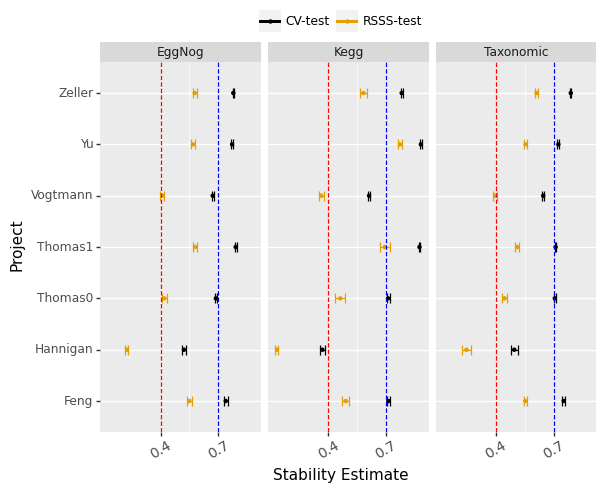

<ggplot: (2999816128005)>

In [513]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete
import plotnine as gg


fname = "stability"
g = (
    ggplot(stab_df)
    + gg.facet_wrap("~Profile")
    + aes(x="Stability", y="Project", color="Analysis")
    + labs(
        x="Stability Estimate",
        y="Project"    )
    + geom_point(size=0.8)
    + scale_x_continuous(breaks=[0.4, 0.7])
    + geom_errorbarh(aes(xmin="low", xmax="up"), height=0.2)
    + geom_vline(xintercept=0.4, linetype="dashed", color="red")
    + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray()
    + theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)


g.save(f"{fname}_analysis.pdf")
g.save(f"{fname}_analysis.svg")
g.save(f"{fname}_analysis.png", dpi=300)
g

/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: auroc_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: auroc_analysis.svg
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: auroc_analysis.png


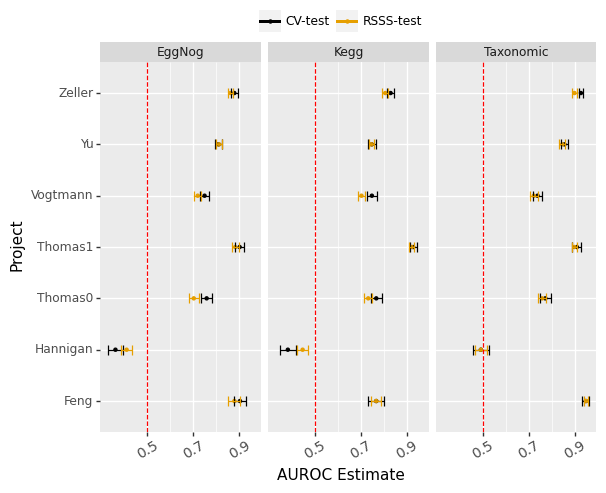

<ggplot: (2999812171241)>

In [514]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete
import plotnine as gg

panel_col = "antiquewhite"

score_name = "AUROC"
fname = "auroc"

X = err_df

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + aes(x=score_name, y="Project", color="Analysis")
    + labs(
        x="AUROC Estimate",
        y="Project"    )
    + geom_point(size=0.8)
    + scale_x_continuous(breaks=[0.5, 0.7, 0.9])
    + geom_errorbarh(aes(xmin="low", xmax="up"), height=0.2)
    + geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(f"{fname}_analysis.pdf")
g.save(f"{fname}_analysis.svg")
g.save(f"{fname}_analysis.png", dpi=300)
g

In [402]:
err_df["score"] = err_df["AUROC"]
err_df["score_name"] = "AUROC"
stab_df["score"] = stab_df["Stability"]
stab_df["score_name"] = "Stability"
df = pd.concat((err_df, stab_df), axis=0, join="inner")
df

,Project,Error,Analysis,Profile,up,low,slog,elog,ulog,llog,score,score_name
0,Vogtmann,0.021227,CV-test,Taxonomic,0.759627,0.717173,2.092585,1.021454,2.137479,2.048633,0.738400,AUROC
1,Thomas1,0.019336,CV-test,Taxonomic,0.928503,0.889831,2.482253,1.019524,2.530717,2.434718,0.909167,AUROC
2,Zeller,0.009483,CV-test,Taxonomic,0.936268,0.917303,2.526376,1.009528,2.550446,2.502532,0.926786,AUROC
3,Feng,0.014730,CV-test,Taxonomic,0.962730,0.933270,2.580543,1.014839,2.618835,2.542811,0.948000,AUROC
4,Yu,0.015090,CV-test,Taxonomic,0.870340,0.840160,2.351962,1.015204,2.387723,2.316738,0.855250,AUROC
...,...,...,...,...,...,...,...,...,...,...,...,...
2,Zeller,0.009993,RSSS-test,eggNog,0.586776,0.566789,1.780301,1.010044,1.798182,1.762598,0.576782,Stability
3,Feng,0.012801,RSSS-test,eggNog,0.562284,0.536683,1.732358,1.012883,1.754676,1.710324,0.549483,Stability
4,Yu,0.009561,RSSS-test,eggNog,0.577172,0.558049,1.764047,1.009607,1.780994,1.747261,0.567610,Stability
5,Hannigan,0.007993,RSSS-test,eggNog,0.233310,0.217324,1.252720,1.008025,1.262772,1.242747,0.225317,Stability


In [403]:
df.score_name.value_counts()

Stability    42
AUROC        42
Name: score_name, dtype: int64

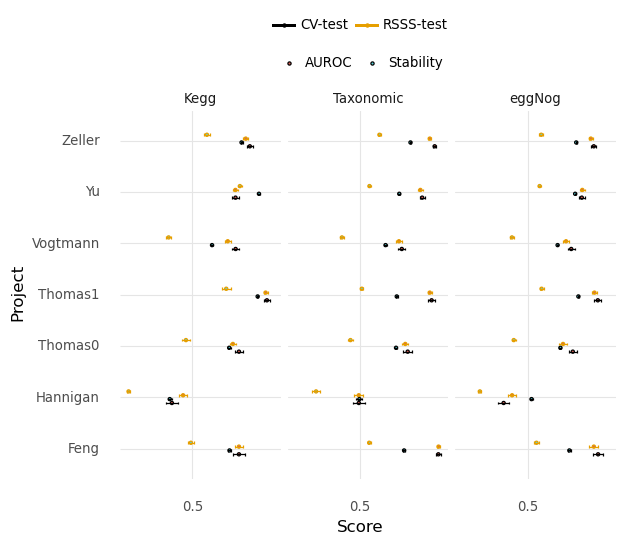

<ggplot: (3000063421201)>

In [404]:
g = (
    ggplot(df)
    + gg.facet_wrap("~Profile")
    + aes(y="score", x="Project", color="Analysis", fill="score_name")
    + labs(
        y="Score",
        x="Project"    )
    + geom_point(size=0.8, position=gg.position_dodge(width=0.3))
    + gg.scale_y_continuous(breaks=[0.5])
    + gg.geom_errorbar(aes(ymin="low", ymax="up"), width=0.2, position=gg.position_dodge(width=0.3))
    #+ geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_minimal(base_size=12)
    + theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            panel_background=gg.element_rect(fill="w", color="w"),
            strip_background=gg.element_rect(fill="w", color="w"),
            plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=0,
           legend_margin=0)
    #+ gg.guide_legend(nrow=1)
    + theme(axis_text_y=element_text(rotation=0, vjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
    
    + gg.coord_flip()
)

g

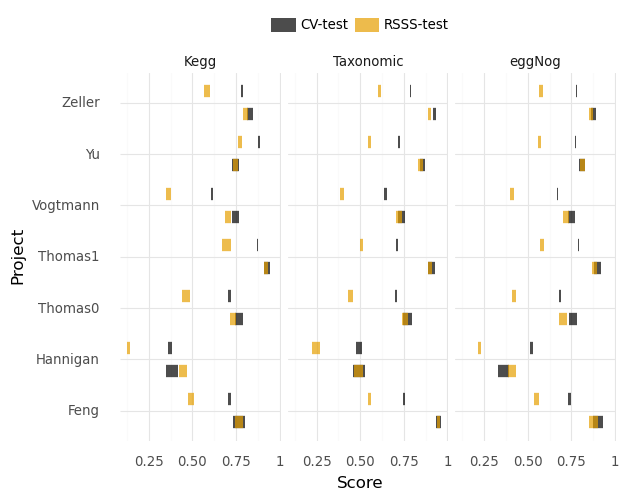

<ggplot: (2999966895541)>

In [438]:
fname = "auroc"
g = (gg.ggplot(df, aes(x="Project", weight="score", ymin="low", ymax="up", color="Analysis", group="score_name")) +
     labs(
        y="Score",
        x="Project"    ) +
     #gg.geom_bar(position=gg.position_dodge(), mapping=aes(y="score"), stat="identity") +
     #gg.geom_point(size=0.001, position=gg.position_dodge(width=0.9), mapping=aes(y="score")) + 
     gg.geom_linerange(size=5, alpha=0.7, position=gg.position_dodge(width=0.9), mapping=aes(y="score")) +
     
     gg.facet_wrap("~Profile") +
     gg.scale_color_manual(COLOR_BLIND_PALETTE)
    + gg.theme_minimal(base_size=12)
    + theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            panel_background=gg.element_rect(fill="w", color="w"),
            strip_background=gg.element_rect(fill="w", color="w"),
            plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=0,
            legend_margin=0)    
     + gg.coord_flip()
     + theme(axis_text_x=element_text(rotation=0, vjust=-0.9))
)

# g.save(f"{fname}_stability.pdf")
# g.save(f"{fname}_stability.svg")
# g.save(f"{fname}_stability.png", dpi=300)
g

In [ ]:
def compute_support_ebm(model: Pipeline, quantile=None):
    # TODO: check if trained
    ebm = model["estimator"]
    ebm_global = ebm.explain_global()
    data = ebm_global.data()

    if "selector" in model.named_steps.keys():
        support = model["selector"].get_support()
    else:
        support = np.repeat(True, len(data["scores"]))

    coefs = np.zeros(support.size)
    coefs[support] = np.array(data["scores"])

    support = support * 1

    return support, coefs

In [588]:
from scipy.stats import linregress, rankdata

def fdr(p_vals):
    ranked_p_values = rankdata(p_vals)
    p_vals_new = p_vals * len(p_vals) / ranked_p_values
    p_vals_new[p_vals_new > 1] = 1

    return p_vals_new

def compute_explanations(pipe, X, name, folder_path, profile_name, conditon="crc"):
    from sklearn.pipeline import Pipeline
    X_trans = Pipeline(pipe.steps[:-1]).transform(features)    
    X_filt = pd.DataFrame(X_trans, index=X.index, columns=X.columns[pipe["selector"].get_support()])
    
    model = pipe["estimator"]
    ebm_local = model.explain_local(X_filt)

    explanations = [ebm_local.data(irow) for irow in range(X_filt.shape[0])]
    explanation_df = pd.concat(
        [pd.Series(x["scores"], index=X_filt.columns, name="score") for x in explanations],
        axis=1,
    )
    explanation_df.columns = X_filt.index
    explanation_df = explanation_df.T

    explanations_reg = [
        linregress(X[col], explanation_df[col]) for col in X_filt.columns
    ]
    explanations_coef = pd.Series(
        [reg[0] for reg in explanations_reg], index=X_filt.columns, name="r_coeff"
    )
    explanations_sig = pd.Series(
        [coef > 0 for coef in explanations_coef], index=X_filt.columns, name="r_sign"
    )
    explanations_pval = pd.Series(
        [reg[3] for reg in explanations_reg], index=X_filt.columns, name="r_pvalue"
    )
    explanations_pval_fdr = pd.Series(
        fdr(explanations_pval), index=X_filt.columns, name="r_pvalue_fdr"
    )

    explanations_rank = explanation_df.abs().mean()
    explanations_rank.name = "score"
    explanations_analysis = pd.concat(
        (explanations_rank, explanations_coef, explanations_sig, explanations_pval, explanations_pval_fdr),
        axis=1,
    )
    
    explanations_analysis = explanations_analysis.sort_values(by="score", ascending=False)

    dataset_fpath = folder_path.joinpath(
        f"{condition}_{profile_name}_{name}_explanations.tsv"
    )
    explanations_analysis.to_csv(dataset_fpath, sep="\t", index_label="feature_id")
    
    return explanations_analysis

In [518]:
profile = "KEGG_KOs"
project = "Thomas1"
pipe = results_cp_dict[profile][project]["cv"]["estimator"][0]

In [520]:
x = pipe["estimator"]

In [525]:
pipe["selector"].get_support().sum()

2475

In [526]:
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)

In [540]:
i=0
explanations_analysis = compute_explanations(pipe, features, name=f"all{i:2d}", folder_path=pathlib.Path("."), profile_name="profile", conditon="crc")

In [603]:
kegg_explanations = {}
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    kegg_explanations[project] = explanations

/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


In [691]:
features.shape

(864, 20254)

In [918]:
import joblib
joblib.dump(kegg_explanations, "kegg_cv_explanations.jbl")
joblib.dump(taxo_explanations, "taxo_cv_explanations.jbl")
joblib.dump(ogs_explanations, "ogs_cv_explanations.jbl")

['ogs_cv_explanations.jbl']

In [703]:
for i, explanation_dict in enumerate([kegg_explanations, taxo_explanations, ogs_explanations]):
    profile = ["kegg", "taxo", "ogs"][i]
    for project in explanation_dict.keys():
        explanation_dict[project].to_csv(f"{profile}_{project}_explanations_cv.tsv", sep="\t")

In [692]:
taxo_explanations = {}
profile="centrifuge"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
tax_id = "9606"
print(tax_id in features.columns)
features = features.drop(tax_id, axis=1)
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    taxo_explanations[project] = explanations

True


/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


In [698]:
ogs_explanations = {}
profile="OGs"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    ogs_explanations[project] = explanations

/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


In [699]:
explanations = ogs_explanations
rank_stabs = {}
df = pd.DataFrame(columns=["stability", "lower", "upper", "Project", "q"])
for project in PROJECT_NAMES_DICT.values():
    x = explanations[project]
    rank_stabs[project] = [stab.confidenceIntervals((x.apply(lambda y: y > np.quantile(y, q)) * 1).T.values) for q in np.arange(0.01, 1, 0.01)]
    d = pd.DataFrame(rank_stabs[project])
    d["Project"] = project
    d["q"] = np.arange(0.01, 1, 0.01)
    df = pd.concat((df, d), axis=0)

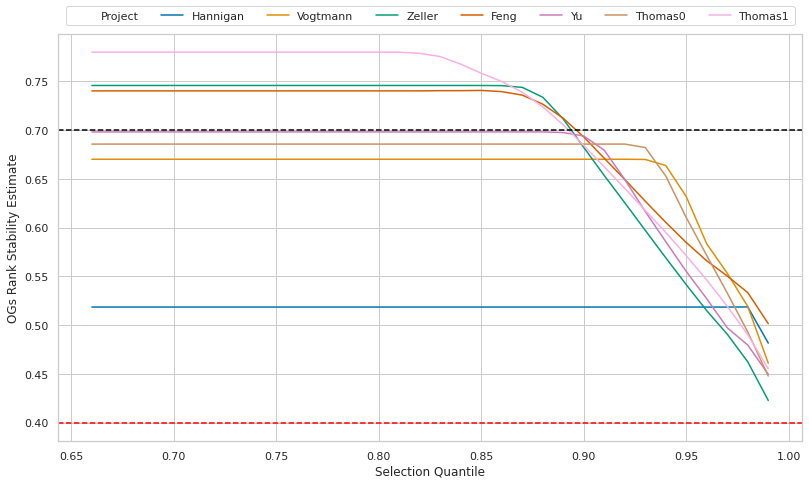

In [700]:
sns.set_context("notebook")
plt.figure(figsize=(16/1.2, 9/1.2))
g = sns.lineplot(data=df.loc[df.q>0.65, :], x="q", y="stability", hue="Project", palette="colorblind")
plt.xlabel("Selection Quantile")
plt.ylabel(f"{profile} Rank Stability Estimate")
plt.axhline(0.4, color="red", linestyle="--")
plt.axhline(0.7, color="black", linestyle="--")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08), ncol=8)
# plt.legend(ncol=len(PROJECT_NAMES_DICT.values()), bbox_to_anchor=(0.05, 1))

In [701]:
features.shape

(864, 252257)

In [731]:
taxo_explanations_stab = {}
profile="centrifuge"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
tax_id = "9606"
print(tax_id in features.columns)
features = features.drop(tax_id, axis=1)
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    explanations.to_csv(f"{profile}_{project}_explanations_stab.tsv", sep="\t")
    taxo_explanations_stab[project] = explanations

True


/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


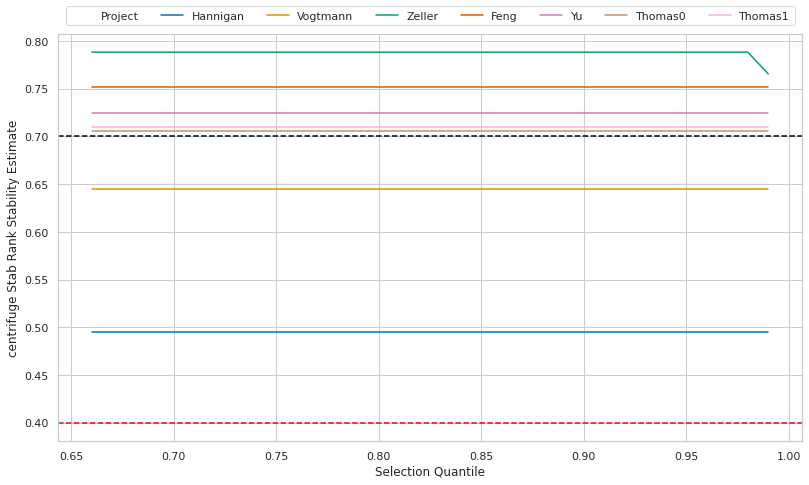

In [732]:
explanations = taxo_explanations_stab
rank_stabs = {}
df = pd.DataFrame(columns=["stability", "lower", "upper", "Project", "q"])
for project in PROJECT_NAMES_DICT.values():
    x = explanations[project]
    rank_stabs[project] = [stab.confidenceIntervals((x.apply(lambda y: y > np.quantile(y, q)) * 1).T.values) for q in np.arange(0.01, 1, 0.01)]
    d = pd.DataFrame(rank_stabs[project])
    d["Project"] = project
    d["q"] = np.arange(0.01, 1, 0.01)
    df = pd.concat((df, d), axis=0)
    
sns.set_context("notebook")
plt.figure(figsize=(16/1.2, 9/1.2))
g = sns.lineplot(data=df.loc[df.q>0.65, :], x="q", y="stability", hue="Project", palette="colorblind")
plt.xlabel("Selection Quantile")
plt.ylabel(f"{profile} Stab Rank Stability Estimate")
plt.axhline(0.4, color="red", linestyle="--")
plt.axhline(0.7, color="black", linestyle="--")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08), ncol=8)
# plt.legend(ncol=len(PROJECT_NAMES_DICT.values()), bbox_to_anchor=(0.05, 1))

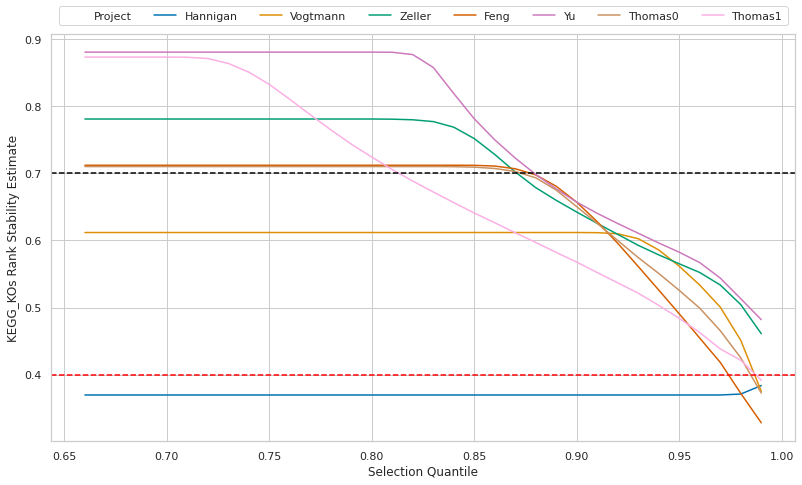

In [689]:
sns.set_context("notebook")
plt.figure(figsize=(16/1.2, 9/1.2))
g = sns.lineplot(data=df.loc[df.q>0.65, :], x="q", y="stability", hue="Project", palette="colorblind")
plt.xlabel("Selection Quantile")
plt.ylabel(f"{profile} Rank Stability Estimate")
plt.axhline(0.4, color="red", linestyle="--")
plt.axhline(0.7, color="black", linestyle="--")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08), ncol=8)
# plt.legend(ncol=len(PROJECT_NAMES_DICT.values()), bbox_to_anchor=(0.05, 1))

In [652]:
len(PROJECT_NAMES_DICT.values())

7

In [674]:
features.shape

(864, 10098)

In [ ]:
function stability = effectiveStabilityWithRedundancy(Z, C)
% Summary
%    Calculates the stability estimator \hat{\Phi}}_{\mathbb{G}(\mathcal{Z})
%    Input: 
%       - Z: a binary matrix of size M*d where each row represents a feature s
%       - C: a matrix d*d that captures which pairs of features are correlated
%      
%    Output:
%       - stability: the stability estimate taking into account groups of features
%%% Numerator
effective_numerator = sum(sum(C.*((cov(Z)))));

%%% Denominator
p_f_element = mean(sum(Z,2))/size(Z,2); 
p_f = repmat(p_f_element,1,size(Z,2));
 
p_ff_element =  mean(sum(Z,2).*(sum(Z,2)-1) )./(size(Z,2)*(size(Z,2)-1));
p_ff = repmat(p_ff_element,size(Z,2),size(Z,2));
p_ff(1:(size(Z,2)+1):end) = p_f_element;

covariance_matrix = p_ff -  p_f' * p_f;
effective_denominator = sum(sum(C.*(((covariance_matrix)))));
 
%%% Effective Stability
stability = 1- effective_numerator/(effective_denominator);


In [726]:
def effectiveStabilityWithRedundancy(Z, C):
    effective_numerator = np.sum(np.sum(np.dot(C, np.cov(Z, rowvar=False))))
    
    p_f_element = np.mean(np.sum(Z, 1)) / Z.shape[1]
    p_f = np.tile(p_f_element, (1, Z.shape[1]))
    
    p_ff_element =  np.mean(np.sum(Z, 1) * (np.sum(Z, 1) - 1)) / (Z.shape[1] * (Z.shape[1] - 1))
    p_ff = np.tile(p_ff_element, (Z.shape[1], Z.shape[1]))
    p_ff[:(Z.shape[1] + 1):] = p_f_element
    
    covariance_matrix = p_ff -  np.dot(p_f.T, p_f)
    effective_denominator = np.sum(np.sum(np.dot(C, covariance_matrix)))
    
    stability = 1 - effective_numerator / (effective_denominator)
    
    return stability

In [727]:
Z.shape

(100, 3)

In [728]:
dim = 3
n_resamples = 100

Z = np.random.randint(2, size=(n_resamples, dim))
C = np.random.randn(dim)
Z.shape, C.shape, np.unique(Z)

((100, 3), (3,), array([0, 1]))

In [729]:
effectiveStabilityWithRedundancy(Z, C)

0.6658234051728227

In [733]:
(features.corr() > 0.9) * 1

KeyboardInterrupt: 

In [735]:
from sklearn.metrics import label_ranking_average_precision_score as lraps


In [737]:
lraps(rank_stabs_kegg, Z)

1.0

In [745]:
explanations = kegg_explanations

q=0.9

project = "Thomas0"
x = explanations[project]
x = (x.apply(lambda y: y > np.quantile(y, q)) * 1).T.values

project = "Thomas1"
y = explanations[project]
y = (y.apply(lambda y: y > np.quantile(y, q)) * 1).T.values

In [746]:
lraps(x, y)

0.0983889472774331

In [744]:
x.shape

(200, 10098)

In [749]:
from scipy.stats import weightedtau
explanations[project]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
K00001,0.041618,0.027738,0.062853,0.054567,0.079847,0.052201,0.062993,0.057508,0.073356,0.080512,...,0.082199,0.077561,0.039359,0.028968,0.032127,0.079097,0.106422,0.047783,0.071198,0.037712
K00002,0.024109,0.040595,0.043656,0.072267,0.047260,0.039724,0.060884,0.053526,0.014442,0.066500,...,0.037290,0.075898,0.028614,0.021588,0.053445,0.053040,0.083773,0.039025,0.044336,0.025290
K00003,0.024804,0.041229,0.062343,0.088343,0.078259,0.049345,0.073533,0.061653,0.061242,0.073755,...,0.054103,0.087848,0.043575,0.033148,0.050954,0.077986,0.130880,0.050023,0.098743,0.031559
K00004,0.020530,0.056462,0.024806,0.031579,0.020138,0.021989,0.021194,0.023453,0.015061,0.027721,...,0.022742,0.019296,0.006092,0.008209,0.029835,0.024051,0.042715,0.015420,0.055725,0.024159
K00005,0.022182,0.018633,0.053989,0.017067,0.034285,0.035288,0.030586,0.021449,0.021672,0.031762,...,0.029985,0.047790,0.018840,0.012505,0.031872,0.024567,0.035555,0.017641,0.033144,0.011951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K20108,0.045420,0.043178,0.000000,0.000000,0.066317,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.084848,0.000000,0.000000,0.000000,0.000000,0.000000,0.039722,0.040338,0.000000
K20109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
K20112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
K20113,0.025929,0.032771,0.041090,0.051053,0.057477,0.029311,0.037916,0.024849,0.028327,0.059713,...,0.000000,0.049486,0.020173,0.012797,0.048203,0.042121,0.064309,0.012468,0.057900,0.026810


In [767]:
PROJECT_ORDER

['Feng', 'Hannigan', 'Thomas0', 'Thomas1', 'Vogtmann', 'Yu', 'Zeller']

In [768]:
explanations = kegg_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project in PROJECT_ORDER:
    wtau = []
    for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

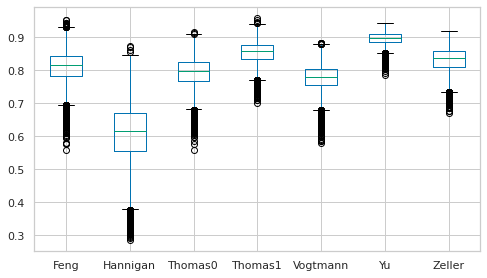

In [770]:
kegg_wtau = wtau_df
kegg_wtau["Profile"] = "Kegg"
kegg_wtau.plot(kind="box", figsize=(16/2, 9/2))

In [ ]:
explanations = ogs_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project in ["Zeller"]:
    wtau = []
    for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

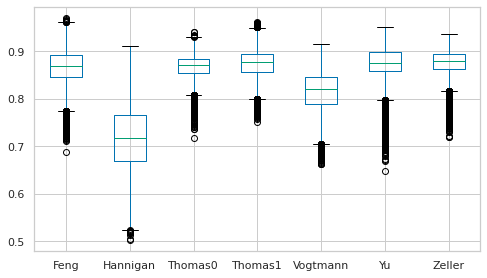

In [784]:
egg_wtau = wtau_df
egg_wtau["Profile"] = "eNog"
egg_wtau.plot(kind="box", figsize=(16/2, 9/2))

In [ ]:
for pr

In [786]:
explanations = taxo_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project in PROJECT_ORDER:
    wtau = []
    for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

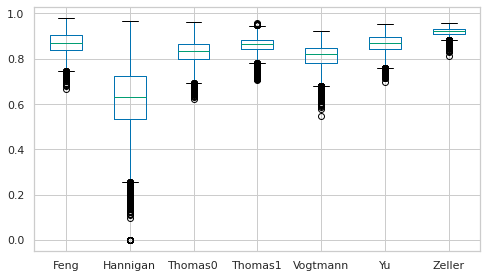

In [787]:
taxo_wtau = wtau_df
taxo_wtau["Profile"] = "Taxo"
taxo_wtau.plot(kind="box", figsize=(16/2, 9/2))

In [794]:
wtau_df = pd.concat((kegg_wtau, egg_wtau, taxo_wtau), axis=0)
wtau_df = wtau_df.melt(id_vars=["Profile"], var_name="Project", value_name="Score")

In [795]:
wtau_df = wtau_df.replace({"Kegg": "Kegg", "Taxo": "Taxonomic", "eNog": "eggNog"})

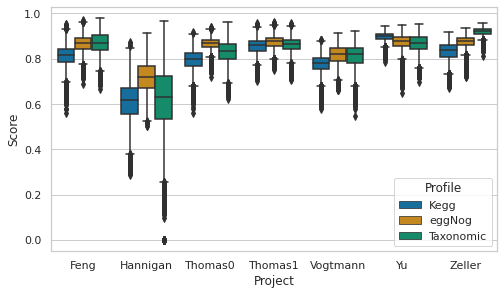

In [796]:
fac = 2
plt.figure(figsize=(16/fac, 9/fac))
sns.boxplot(data=wtau_df, x="Project", y="Score", hue="Profile", palette="colorblind")

In [786]:
explanations = taxo_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project_x in PROJECT_ORDER:
    for i in range(explanations[project].shape[1])
    for project_y in PROJECT_ORDER:
        wtau = []
        for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

In [797]:
from sklearn.metrics import pairwise_distances


In [799]:
distance = lambda x, y: weightedtau(x, y)[0]

In [802]:
PROJECT_ORDER

['Feng', 'Hannigan', 'Thomas0', 'Thomas1', 'Vogtmann', 'Yu', 'Zeller']

In [805]:
project_x = PROJECT_ORDER[2]
project_y = PROJECT_ORDER[3]

In [806]:
kegg_pairwise = {}

In [809]:
kegg_pairwise[(project_x, project_y)] = pairwise_distances(
    kegg_explanations[project_x].T.iloc[:100, :], 
    kegg_explanations[project_y].T.iloc[:100, :],
    metric=distance,
    n_jobs=-1)

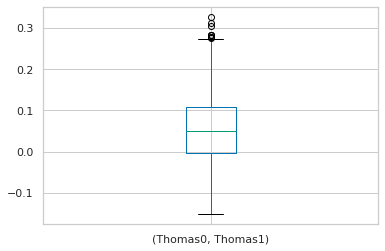

In [815]:
pd.Series(kegg_pairwise[(project_x, project_y)].ravel(), name=f"({project_x}, {project_y})").plot(kind="box")

In [858]:
condition = "CRC"
profile = "centrifuge"

In [879]:
rpath = results_folder.joinpath(condition.lower(), f"{condition.lower()}_{profile.lower()}_results")
fpath = rpath.joinpath(f"{condition}_{profile}_lopo_with _oracle_support.tsv")
features_used = pd.read_csv(fpath, sep="\t", index_col=0).index.astype(str)
features_used

Index(['33033', '469607', '879243', '29391', '1841863', '294', '2718',
       '1160721', '76857', '39950', '1122984', '143387', '525283', '582',
       '539', '457405', '1156431', '28135', '1447716', '546269', '1750',
       '172042', '1104322', '712122', '566552', '2584943', '2564099', '44742',
       '295405', '1304', '1785995', '1582259', '76859', '536231', '562',
       '2109692', '862971', '1384484', '1048332', '1509', '155615', '264199',
       '1335', '40324', '1150460', '1839799', '1912856', '2487118', '388919',
       '515620', '649756', '1744', '706439', '1680', '28131', '28025',
       '537007', '2109691', '585394', '767031', '1385942', '1307443',
       '1759399', '2509456', '1305', '469604', '182773', '767463', '1340',
       '2479767', '1229621', '1042156', '34105', '515619', '39488', '28038',
       '1870984', '1308', '853', '361101', '1685', '817', '469615', '856',
       '712357', '272559', '469602', '190304'],
      dtype='object')

In [838]:
features_used.shape

(13514,)

In [839]:
features.shape

(864, 20253)

In [840]:
metadata.shape

(864, 161)

In [898]:
y = metadata.DISEASE.str.lower() == "crc"

In [851]:
projects = metadata.PROJECT.copy()
projects = projects.replace(PROJECT_NAMES_DICT)

In [867]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate

In [853]:
lopo = LeaveOneGroupOut().split(features, y, projects)

In [860]:
from sklearn.feature_selection import SelectKBest
from mlgut.models import get_taxonomic_model

In [856]:
features.shape[1] / 10

2025.3

In [857]:
features.shape[1]

20253

In [873]:
import numpy as np
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.feature_selection import SelectFdr, SelectFpr, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer

In [902]:
model = Pipeline(
    [
        ("transformer", FunctionTransformer(np.log1p)),
        ("discretizer", KBinsDiscretizer(n_bins=4, encode="ordinal")),
        (
            "estimator",
            ExplainableBoostingClassifier(
                n_estimators=24, n_jobs=-1, random_state=42
            ),
        ),
    ]
)

In [899]:
%%capture cap
lopo = LeaveOneGroupOut().split(features, y, projects)
cvres = cross_validate(model, features, y, cv=lopo, return_estimator=True)

KeyboardInterrupt: 

In [900]:
cvres["test_score"].mean()

0.7433276200024664

In [901]:
n_repeats = 22

In [904]:
%%capture cap
cvres = [cross_validate(model, features[features_used], y, cv=LeaveOneGroupOut().split(features, y, projects), return_estimator=True) for _ in range(n_repeats)]

KeyboardInterrupt: 

In [905]:
cvscore = [x["test_score"].mean() for x in cvres]
cvscore

TypeError: string indices must be integers

In [ ]:
projects_unique = np.unique_(projects)
for i, res in enumerate(cvres):
    project_out = projects_unique[i]
    pd.concat([pd.Series(compute_support_ebm(m), index=features_used) for m in res['estimator']])        

In [919]:
"hola"


'hola'

In [922]:
taxo_explanations_stab = {}
profile="centrifuge"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
tax_id = "9606"
print(tax_id in features.columns)
features = features.drop(tax_id, axis=1)
for project in PROJECT_NAMES_DICT.values():
    print(f"start {project}")
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    taxo_explanations_stab[project] = explanations
    print(f"finished {project}")
joblib.dump(taxo_explanations_stab, "taxo_stab_explanation.jbl")

True
start Hannigan
finished Hannigan
start Vogtmann


/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


finished Vogtmann
start Zeller
finished Zeller
start Feng
finished Feng
start Yu
finished Yu
start Thomas0
finished Thomas0
start Thomas1
finished Thomas1


['taxo_stab_explanation.jbl']

In [925]:
kegg_explanations_stab = {}
profile="KEGG_KOs"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
for project in PROJECT_NAMES_DICT.values():
    print(f"start {project}")
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    kegg_explanations_stab[project] = explanations
    print(f"finished {project}")
joblib.dump(kegg_explanations_stab, "kegg_stab_explanation.jbl")

start Hannigan
finished Hannigan
start Vogtmann


/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


finished Vogtmann
start Zeller
finished Zeller
start Feng
finished Feng
start Yu
finished Yu
start Thomas0
finished Thomas0
start Thomas1
finished Thomas1


['kegg_stab_explanation.jbl']

In [926]:
ogs_explanations_stab = {}
profile="OGs"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
for project in PROJECT_NAMES_DICT.values():
    print(f"start {project}")
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    ogs_explanations_stab[project] = explanations
    print(f"finished {project}")
joblib.dump(ogs_explanations_stab, "ogs_stab_explanation.jbl")

start Hannigan


/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less


finished Hannigan
start Vogtmann
finished Vogtmann
start Zeller
finished Zeller
start Feng
finished Feng
start Yu
finished Yu
start Thomas0
finished Thomas0
start Thomas1
finished Thomas1


['ogs_stab_explanation.jbl']

In [ ]:
profiles = ["Taxonomic", "eggNog", "Kegg"]

df = pd.DataFrame(columns=PROJECT_ORDER + ["Profile"])

for profile in profiles:
    print(f"start profile {profile}")
    if profile == "Taxonomic":
        explanations = taxo_explanations_stab
    elif profile == "Kegg":
        explanations = kegg_explanations_stab
    elif profile == "eggNog":
        explanations = ogs_explanations_stab
    df_i = pd.DataFrame(columns=PROJECT_ORDER)
    for project in PROJECT_ORDER:
        print(f"start project {project}")
        wtau = []
        for i in range(explanations[project].shape[1]):
            for j in range(i+1, explanations[project].shape[1]):
                wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
        df_i[project] = wtau
        print(f"end project {project}")
    df_i["Profile"] = profile
    df = pd.concat((df, df_i), axis=0)
    print(f"end profile {profile}")
    print("")
df["Analysis"] = "RSSS-test"
stab_rank = df.copy()

start profile Taxonomic
start project Feng
end project Feng
start project Hannigan
end project Hannigan
start project Thomas0
end project Thomas0
start project Thomas1
end project Thomas1
start project Vogtmann
end project Vogtmann
start project Yu
end project Yu
start project Zeller
end project Zeller
end profile Taxonomic

start profile eggNog
start project Feng
end project Feng
start project Hannigan
end project Hannigan
start project Thomas0
end project Thomas0
start project Thomas1
end project Thomas1
start project Vogtmann
end project Vogtmann
start project Yu
end project Yu
start project Zeller


In [937]:
cv_rank = pd.concat((kegg_wtau, egg_wtau, taxo_wtau), axis=0).copy().replace({"Kegg": "Kegg", "Taxo": "Taxonomic", "eNog": "eggNog"})
cv_rank["Analysis"] = "CV-test"

In [938]:
wtau_df = stab_rank.melt(id_vars=["Profile", "Analysis"], var_name="Project", value_name="Score")

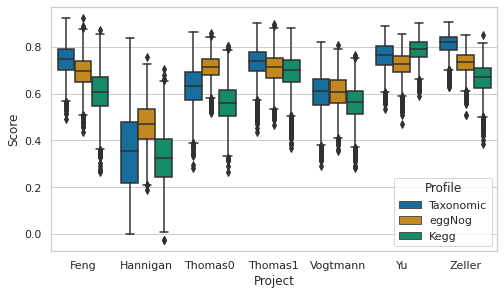

In [939]:
fac = 2
plt.figure(figsize=(16/fac, 9/fac))
sns.boxplot(data=wtau_df, x="Project", y="Score", hue="Profile", palette="colorblind")

In [940]:
rank_df = pd.concat((cv_rank, stab_rank), axis=0)
rank_df.to_csv("rank.tsv", sep="\t", index=False)

In [942]:
df = rank_df.melt(id_vars=["Profile", "Analysis"], var_name="Project", value_name="Score")

/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: rank_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: rank_analysis.svg
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/mlgut/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: rank_analysis.png


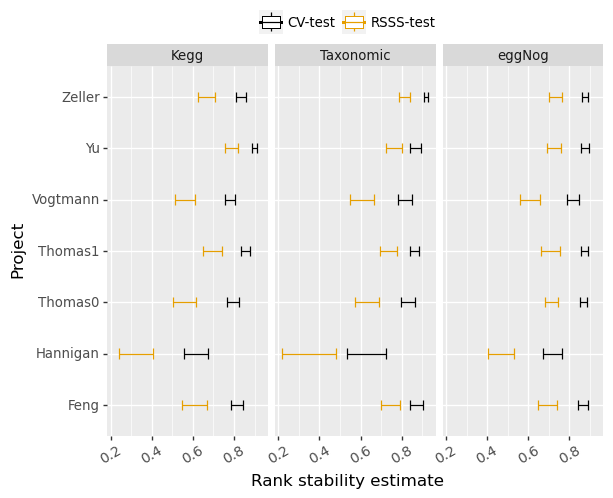

<ggplot: (2999713873901)>

In [977]:
panel_col = "antiquewhite"

score_name = "mean"
fname = "rank"
xlab_str = "Rank stability estimate"

X = df.groupby(["Profile", "Analysis", "Project"])["Score"].describe()[["mean", "25%", "75%"]].reset_index()

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + aes(x=score_name, y="Project", color="Analysis")
    + labs(
        x=xlab_str,
        y="Project"    )
    #+ geom_point(size=0.8)
    #+ scale_x_continuous(breaks=[0.5, 0.7, 0.9])
    + geom_errorbarh(aes(xmin="25%", xmax="75%"), height=0.2)
    + gg.geom_boxplot()
    #+ geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(f"{fname}_analysis.pdf")
g.save(f"{fname}_analysis.svg")
g.save(f"{fname}_analysis.png", dpi=300)
g

In [979]:
err_df.to_csv("error_summary.tsv", sep="\t", index=False)

In [982]:
stab_df.to_csv("stability_summary.tsv", sep="\t", index=False)

In [983]:
X.to_csv("rank_summary.tsv", sep="\t", index=False)